# Import Packages

All packages used in this notebook have been imported. 

In [2]:
# data source and handling
import cdsapi
import xarray as xr
import numpy as np
import pandas as pd

# plotting 
import matplotlib.pyplot as plt 
import seaborn as sns
import matplotlib.dates as mdates
from matplotlib.dates import HourLocator, DateFormatter

# model training
from scipy.signal import periodogram
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.api import VAR
from pydmd import DMD, EDMD
from numpy.linalg import pinv
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures

# evaluation
from sklearn.metrics import mean_squared_error

#misc
import zipfile
from pathlib import Path
from tqdm import tqdm


# Data Preparation

The ERA5 Land hourly time-series data data is obtained from Copernics Climate Data Store (CDS) https://cds.climate.copernicus.eu/datasets/reanalysis-era5-single-levels-timeseries?tab=overview. The near-surface temperature, denoted by `2m_temperature`, is extracted for the location of New Delhi. 

First, let's specify the details for retrieving our data. We obtain the data for Apr - Jun 2025 (the data for Jun 2025 is up to 15th June) at every hour for a bounding box of Delhi. 

In [ ]:
# Grid: North, West, South, East (based on longitude & latitude)
region = [29.1, 76.7, 28.1, 77.7]  # small grid around Delhi (note that the city spans multiple latitude, longittude indices so we have to take a "box"/"grid" that spans across few indices covering Delhi)

# Explore the Apr - Jun period of this year 
year = ['2025']
months = ['04', '05', '06']

# Variable - 2m temperature 
var = '2m_temperature'

Then, the CDS API is used to retrieve and save the data. 

In [ ]:
cds_client = cdsapi.Client()

cds_client.retrieve(
    'reanalysis-era5-land',
    {
        'variable': var,
        'year': year,
        'month': months, 
        'day': [f'{d:02d}' for d in range(1, 31+1)],
        'time': [f'{h:02d}:00' for h in range(24)],
        'area': region,
        'format': 'netcdf',
    },
    './data/delhi_temp_grid.zip')   # download and save the data locally in directory 


The above code downloads that data into a zip. The grid data is saved as a netCDF (a file format for grid data, such as the one involving spatio-temporal data points) which needs to be first extracted from the zip. 

In [7]:
# Extract the zip archive
output_dir = Path('./data')
with zipfile.ZipFile('./data/delhi_temp_grid.zip', 'r') as zip_ref:
    zip_ref.extractall(output_dir)

In [8]:
# Show extracted files
extracted_files = list(output_dir.glob('*.nc'))
print("Extracted NetCDF files:", extracted_files)

Extracted NetCDF files: [PosixPath('data/data_0.nc'), PosixPath('data/usable.nc')]


Now, we load the grid data. 

In [3]:
data = xr.open_dataset('./data/data_0.nc')  # or whatever the actual filename is
print(data)

<xarray.Dataset> Size: 931kB
Dimensions:     (valid_time: 1833, latitude: 11, longitude: 11)
Coordinates:
    number      int64 8B ...
  * valid_time  (valid_time) datetime64[ns] 15kB 2025-04-01 ... 2025-06-16T08...
  * latitude    (latitude) float64 88B 29.1 29.0 28.9 28.8 ... 28.3 28.2 28.1
  * longitude   (longitude) float64 88B 76.7 76.8 76.9 77.0 ... 77.5 77.6 77.7
    expver      (valid_time) <U4 29kB ...
Data variables:
    t2m         (valid_time, latitude, longitude) float32 887kB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-06-21T08:25 GRIB to CDM+CF via cfgrib-0.9.1...


Take note of the dimensions of the dataset: 
- `valid_time`: the timestamps for every hour 
- `latitude`, `longitude`: the long/lat spatial grid that spans New Delhi 

Then, the data variables (the observed value) is `t2m` which corresponds to the 2-meter (near surface) air, sampled hourly over a spatial grid covering the New Delhi metropolitan region. This variable has a dimension of (time_len, latitutde, longitude)

# Data Exploration

Before performing any modelling techniques, we will first explore our data to understand what it looks like. 

Note that the original dataset measures temperature in Kelvin. For ease of interpretation, we will convert it to Celcius.

In [4]:
# Select the variable
temp = data['t2m']
# Convert from Kelvin to Celsius
temp_c = temp - 273.15

### Daily Mean Temperature

For getting a simplistic view of the data, we first plot each day's min, max and mean temperature to reveal any seasonal trends across the months of Apr-Jun 2025. To aggregate the spatial data, we also take the central grid point. 

In [5]:
plt.style.use('ggplot')

In [8]:
# Pick central grid point (roughly middle of the latitude/longitude arrays)
lat_mid = temp_c.latitude.values[len(temp_c.latitude) // 2]
lon_mid = temp_c.longitude.values[len(temp_c.longitude) // 2]

# Extract time series
ts_central = temp_c.sel(latitude=lat_mid, longitude=lon_mid)

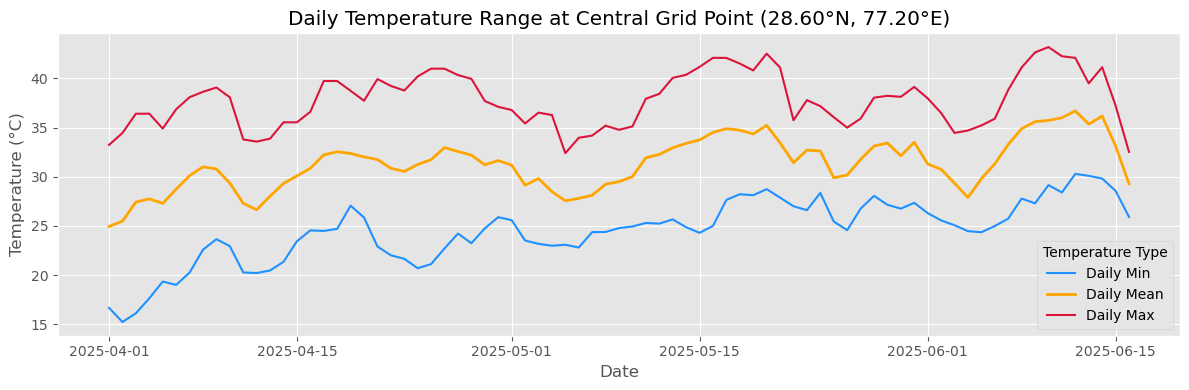

In [9]:
# Compute all three daily statistics
daily_min = ts_central.resample(valid_time='1D').min()
daily_mean = ts_central.resample(valid_time='1D').mean()
daily_max = ts_central.resample(valid_time='1D').max()

# Plotting
plt.figure(figsize=(12, 4))

# Plot each line
sns.lineplot(x=daily_min['valid_time'], y=daily_min.values, label='Daily Min', color='dodgerblue', linewidth=1.5)
sns.lineplot(x=daily_mean['valid_time'], y=daily_mean.values, label='Daily Mean', color='orange', linewidth=2)
sns.lineplot(x=daily_max['valid_time'], y=daily_max.values, label='Daily Max', color='crimson', linewidth=1.5)

# Plot styling
plt.title(f"Daily Temperature Range at Central Grid Point ({lat_mid:.2f}°N, {lon_mid:.2f}°E)")
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.legend(title="Temperature Type")
plt.tight_layout()
plt.show()


The min, mean, and max temperature fluctuates throughout the period, with higher overall temperatures seen around the middle of each month and towards June. We also see that the difference of the min/max temperatures from the mean temperature is lesser in June, which suggests that June experiences more stable but warmer temperatures. 

### Hourly Time Series at a Central Grid Point

Now that we have observed the daily mean temperature data, we can zoom in a little more and view the same data for every hour. In other words, we do not average the temperature anymore. However, we still stick to the central grid point. 

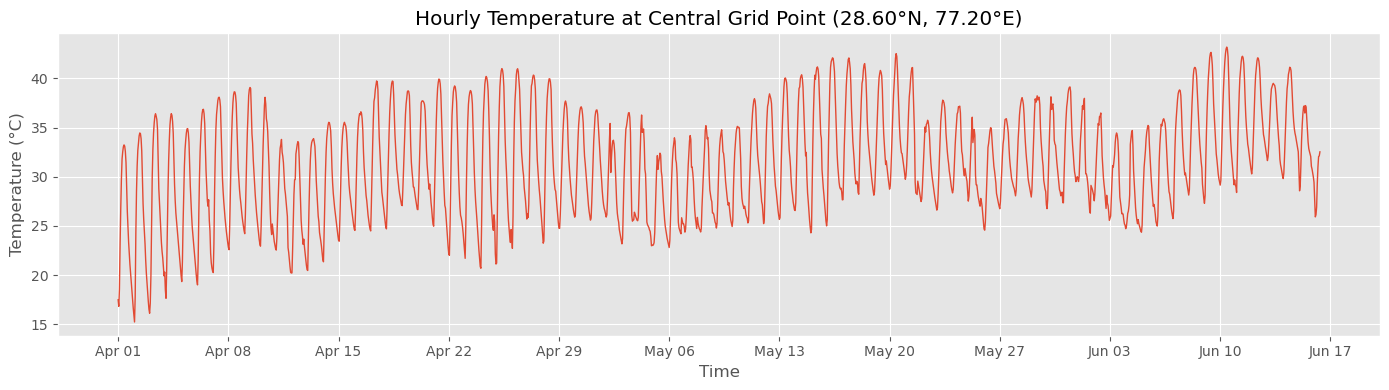

In [10]:
fig, ax = plt.subplots(figsize=(14, 4))
ts_central.plot(ax=ax, linewidth=1)

# Set title and labels
ax.set_title(f"Hourly Temperature at Central Grid Point ({lat_mid:.2f}°N, {lon_mid:.2f}°E)")
ax.set_ylabel("Temperature (°C)")
ax.set_xlabel("Time")

# Improve x-axis tick formatting
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))  # Show one tick per week
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))    # Format as 'Apr 01', 'May 01', etc.

plt.grid(True)
plt.tight_layout()
plt.show()


We can pick 3 specific days for a better view. 

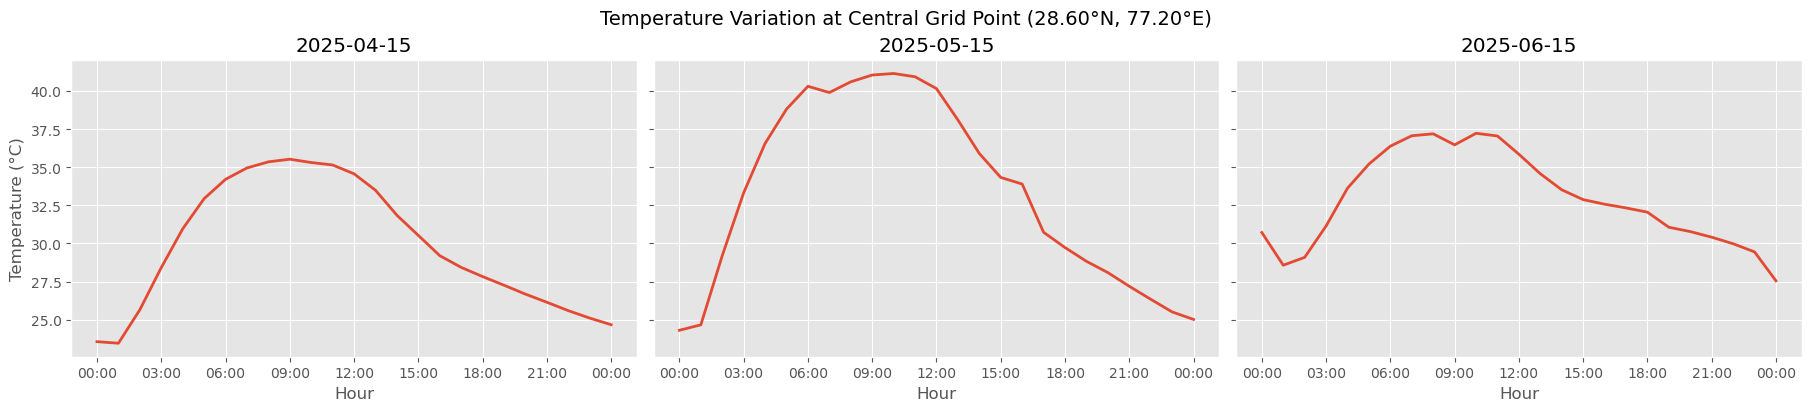

In [11]:
# Extract 3 days of data
selected_dates = ['2025-04-15', '2025-05-15', '2025-06-15']
fig, axes = plt.subplots(1, 3, figsize=(18, 4), sharey=True, constrained_layout=True)

for i, date_str in enumerate(selected_dates):
    start = np.datetime64(date_str)
    end = start + np.timedelta64(1, 'D')
    ts_day = ts_central.sel(valid_time=slice(start, end))
    
    axes[i].plot(ts_day['valid_time'], ts_day.values, linewidth=2)
    axes[i].set_title(f"{date_str}")
    axes[i].set_xlabel("Hour")
    
    # Set hourly ticks every 3 hours starting from 00:00
    axes[i].xaxis.set_major_locator(HourLocator(byhour=range(0, 24, 3)))
    axes[i].xaxis.set_major_formatter(DateFormatter('%H:%M'))

axes[0].set_ylabel("Temperature (°C)")
fig.suptitle(f"Temperature Variation at Central Grid Point ({lat_mid:.2f}°N, {lon_mid:.2f}°E)", fontsize=14)
plt.show()


As seen from the plots, the temperature peaks at around 6am-12pm after which it decays until midnight. Over the course of Apr-Jun, we can say that the temperature trends oscillates and shows a somewhat periodic behavior. 

### Spatial Heatmap of One Day

We can further narrow our scope by visualizing the temperature distribution across the spatial grid spanning Delhi at a single time point. We pick 12pm of 15th of each month Apr-Jun 2025. 

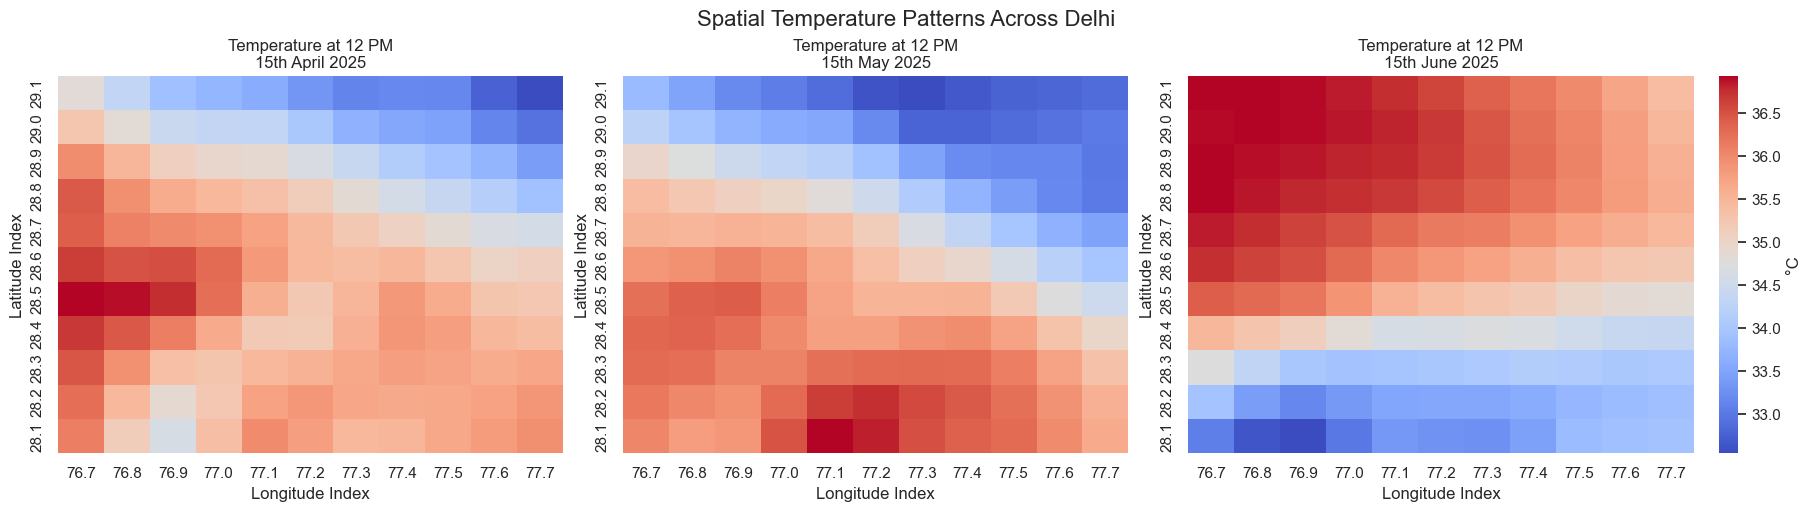

In [13]:
sns.set(style="white")

# Dates to visualize
dates = ['2025-04-15T12:00', '2025-05-15T12:00', '2025-06-15T12:00']
titles = ['15th April 2025', '15th May 2025', '15th June 2025']

# Set up subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5), constrained_layout=True)

# Latitude and longitude tick labels (rounded for readability)
xticks = np.round(temp_c.longitude.values, 2)
yticks = np.round(temp_c.latitude.values, 2)

for i, date in enumerate(dates):
    snapshot = temp_c.sel(valid_time=date)
    
    sns.heatmap(snapshot.values,
                xticklabels=xticks,  
                yticklabels=yticks,
                cmap='coolwarm',
                ax=axes[i],
                cbar=i == 2,  # Only show colorbar on the last plot
                cbar_kws={'label': '°C'} if i == 2 else None)
    
    axes[i].set_title(f"Temperature at 12 PM\n{titles[i]}")
    axes[i].set_xlabel("Longitude Index")
    axes[i].set_ylabel("Latitude Index")

plt.suptitle("Spatial Temperature Patterns Across Delhi", fontsize=16)
plt.show()


The maps show a warming trend across these 3 dates, with temperatures rising steadily across the region. Heat also intensifies from west to east and north to south, with June showing the highest values. 

### Histogram of All Temperature Values

A histogram of all temperature values gives a statistical overview of the entire dataset — useful to check for skewness, multimodality, and temperature extremes.

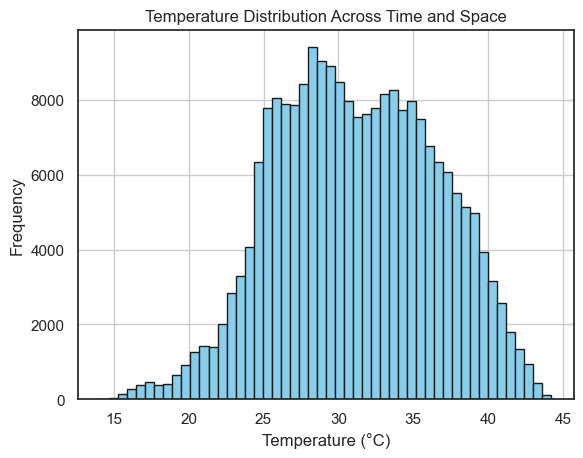

In [14]:
# Flatten and plot histogram
temp_c.values.flatten()

plt.hist(temp_c.values.flatten(), bins=50, color='skyblue', edgecolor='k')
plt.title("Temperature Distribution Across Time and Space")
plt.xlabel("Temperature (°C)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


The temperatures in Apr-Jun 2025 range from approximately 14 to 44 degrees Celcius, with most of the hours experiencing temperatures around 25-37 degrees Celcius. 

# Baseline Modelling 

Now that we have explored our data, let us implement some baseline prediction models. These models use the original high dimensional data where for each timestamp, we have a vector size of our spatial dimension

In [6]:
print("Time steps:", data.sizes['valid_time'])
print("Latitudes:", data.sizes['latitude'])
print("Longitudes:", data.sizes['longitude'])

Time steps: 1833
Latitudes: 11
Longitudes: 11


Our data has a dimensionality of $11 \times 11 = 121$, i.e., each data point lies in $\mathbb{R}^{121}$. We will flatten the data accordingly. 



In [7]:
data['t2m'].shape

(1833, 11, 11)

In [8]:
# Flatten t2m across space
X = data['t2m'].values.reshape(len(data['valid_time']), -1)  # shape: (1833, 121)
print("Flattened shape:", X.shape)  # Time × Flattened grid

Flattened shape: (1833, 121)


A train-test split is also done to ensure an accurate and representative model evaluation. 

In [89]:
# 80% training data, 20% testing data 
X_train, X_test = train_test_split(X, test_size=0.2, shuffle=False)

# convert to celcius 
X_train_C = X_train - 273.15
X_test_C = X_test - 273.15

print("Train shape:", X_train_C.shape)
print("Test shape:", X_test_C.shape)

Train shape: (1466, 121)
Test shape: (367, 121)


## Periodic Regression

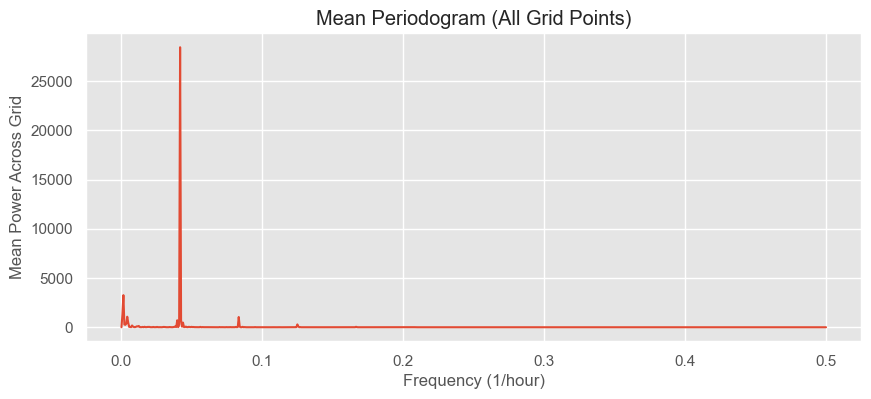

Dominant frequency across grid: 0.04161
Global dominant period: 24.03 hours


In [136]:
# `X_train` has shape (time_steps, 121)
n_time, n_space = X_train_C.shape

# Store periodograms for all grid points
all_power_spectra = []
frequencies = None  # will be same for all

# Compute periodogram for each spatial point
for i in range(n_space):
    freqs, power = periodogram(X_train_C[:, i])
    all_power_spectra.append(power)
    if frequencies is None:
        frequencies = freqs

# Stack into array: shape (121, N_freqs)
power_array = np.stack(all_power_spectra, axis=0)

# Mean power across grid points
mean_power = power_array.mean(axis=0)

# Plot mean periodogram
plt.figure(figsize=(10, 4))
plt.plot(frequencies, mean_power)
plt.xlabel("Frequency (1/hour)")
plt.ylabel("Mean Power Across Grid")
plt.title("Mean Periodogram (All Grid Points)")
plt.grid(True)
plt.show()

# Find dominant frequency (ignore 0 freq)
idx_max = np.argmax(mean_power[1:]) + 1
dominant_frequency = frequencies[idx_max]
dominant_period = 1.0 / dominant_frequency

print(f"Dominant frequency across grid: {dominant_frequency:.5f}")
print(f"Global dominant period: {dominant_period:.2f} hours")


As seen from the periodogram, the dominant period is approx 24 hours. This is consistent with what we saw in our hourly time series plots, where temperature seems to generally oscillate between warmer in day and cooler at night.  

With this period, we generate Fourier features

In [137]:
def generate_features(t: np.ndarray, period: float, num_harmonics: int = 3) -> np.ndarray:
    """
    Generate Fourier basis features for time array `t` with given period.
    """
    features = []
    for j in range(1, num_harmonics + 1):
        features.append(np.sin(2 * np.pi * j * t / period))
        features.append(np.cos(2 * np.pi * j * t / period))
    return np.stack(features, axis=1)  # shape (T, 2 * num_harmonics)


In [138]:
# Time arrays
t_train = np.arange(X_train_C.shape[0])
t_test = np.arange(X_test_C.shape[0])

# Your full harmonic feature generator
features_train = generate_features(t_train, dominant_period)
features_test = generate_features(t_test, dominant_period)

In [139]:
n_train, n_space = X_train_C.shape
X_pred_train_period = np.zeros_like(X_train_C)
X_pred_test_period = np.zeros_like(X_test_C)

for i in range(n_space):
    y_train = X_train_C[:, i]
    reg = LinearRegression().fit(features_train, y_train)
    
    X_pred_train_period[:, i] = reg.predict(features_train)
    X_pred_test_period[:, i] = reg.predict(features_test)

# Evaluate
mse_train = mean_squared_error(X_train_C, X_pred_train_period)
mse_test = mean_squared_error(X_test_C, X_pred_test_period)

print(f"Train MSE: {mse_train:.4f}")
print(f"Test MSE: {mse_test:.4f}")

Train MSE: 8.2983
Test MSE: 17.2321


The results can be visualized by plotting the true vs predicted outputs on one of the grid points. The central grid index is picked. 

In [ ]:
# Original time array from Xarray
times_all = data['valid_time'].values

times_train = times_all[:X_train_C.shape[0]]
times_test = times_all[X_train_C.shape[0]:]

# Time
dates_train = pd.to_datetime(times_train)
dates_test = pd.to_datetime(times_test)

# for visualizaing a sample, we pick the center grid point
center_idx = 121 // 2

x_train = X_train_C[:, center_idx]
x_test = X_test_C[:, center_idx]
center_pred_train_period = X_pred_train_period[:, center_idx]
center_pred_test_period = X_pred_test_period[:, center_idx]

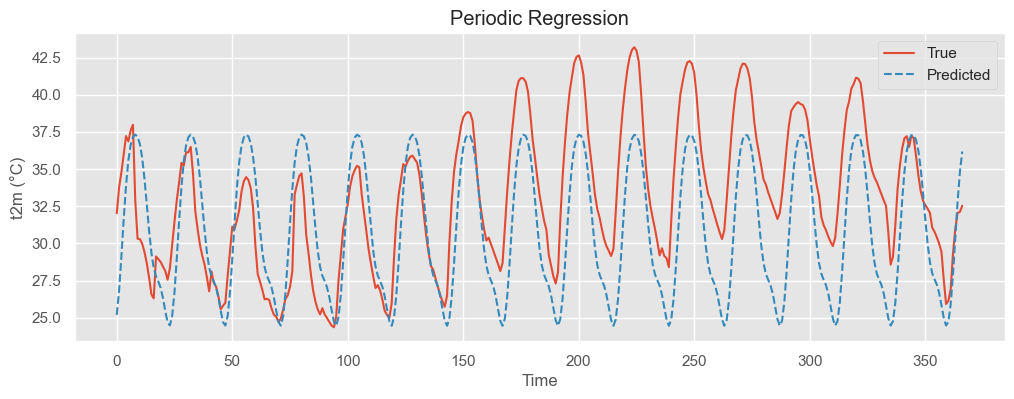

In [144]:
plt.figure(figsize=(12, 4))
plt.plot(x_test, label="True")
plt.plot(center_pred_test_period, '--', label="Predicted")
plt.title(f"Periodic Regression Prediction\n(Center Grid Point: {data.latitude.values[5]:.2f}°N, {data.longitude.values[5]:.2f}°E)")
plt.xlabel("Time")
plt.ylabel("t2m (°C)")
plt.legend()
plt.grid(True)
plt.show()


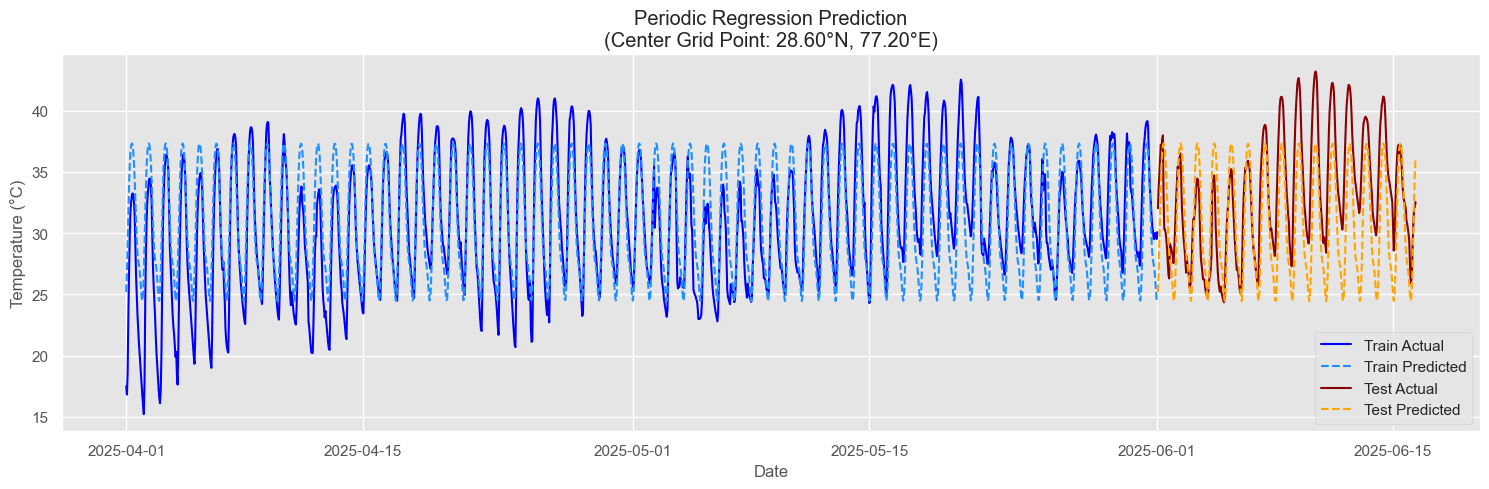

In [146]:
# Plot
plt.figure(figsize=(15, 5))

sns.lineplot(x=dates_train, y=x_train, label='Train Actual', color='blue')
sns.lineplot(x=dates_train, y=center_pred_train_period, label='Train Predicted', color='dodgerblue', linestyle='--')
sns.lineplot(x=dates_test, y=x_test, label='Test Actual', color='darkred')
sns.lineplot(x=dates_test, y=center_pred_test_period, label='Test Predicted', color='orange', linestyle='--')

plt.title(f"Periodic Regression Prediction\n(Center Grid Point: {data.latitude.values[5]:.2f}°N, {data.longitude.values[5]:.2f}°E)")
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.tight_layout()
plt.legend()
plt.show()

The periodic model has successfully capture the general periodic daily trends of higher temperatures in the day and lower temperatures at night. However, it fails to capture other dependencies temperature fluctuations within a day/from one day to another.

## VAR(p)

The next model we implemented is the VAR(p) model, which is essentially the AR(p) model but for multivariate data. 

To pick the best order p, a cross validation is performed. 

In [135]:
# Further split X_train_C into training and validation for CV
split_val = int(0.8 * len(X_train_C))
X_train_subs, X_val = X_train_C[:split_val], X_train_C[split_val:]

# Cross-validation to select best p
p_range = range(1, 101, 10)
val_mse_list = []

for p in tqdm(p_range):
    model = VAR(X_train_subs)
    result = model.fit(maxlags=p)
    forecast_val = result.forecast(y=X_train_subs[-result.k_ar:], steps=len(X_val))
    mse_val = mean_squared_error(X_val, forecast_val)
    val_mse_list.append(mse_val)

best_p = p_range[np.argmin(val_mse_list)]
print(f"Selected AR order: p = {best_p}")

100%|██████████| 10/10 [01:08<00:00,  6.90s/it]

Selected AR order: p = 71


In [136]:
# Re-train VAR on full X_train_C with best p
model_final = VAR(X_train_C)
result_final = model_final.fit(maxlags=best_p)

In [137]:
# Forecast on train and test
X_pred_train_VAR = result_final.fittedvalues  # For training (starts after lag)
X_pred_test_VAR = result_final.forecast(y=X_train_C[-result_final.k_ar:], steps=len(X_test))

# Compute MSE
mse_train = mean_squared_error(X_train_C[result_final.k_ar:], X_pred_train_VAR)
mse_test = mean_squared_error(X_test_C, X_pred_test_VAR)

print(f"Train MSE: {mse_train:.4f}")
print(f"Test MSE: {mse_test:.4f}")

Train MSE: 0.0000
Test MSE: 77.8035


In [138]:
center_pred_train_VAR = X_pred_train_VAR[:, center_idx]
center_pred_test_VAR = X_pred_test_VAR[:, center_idx]

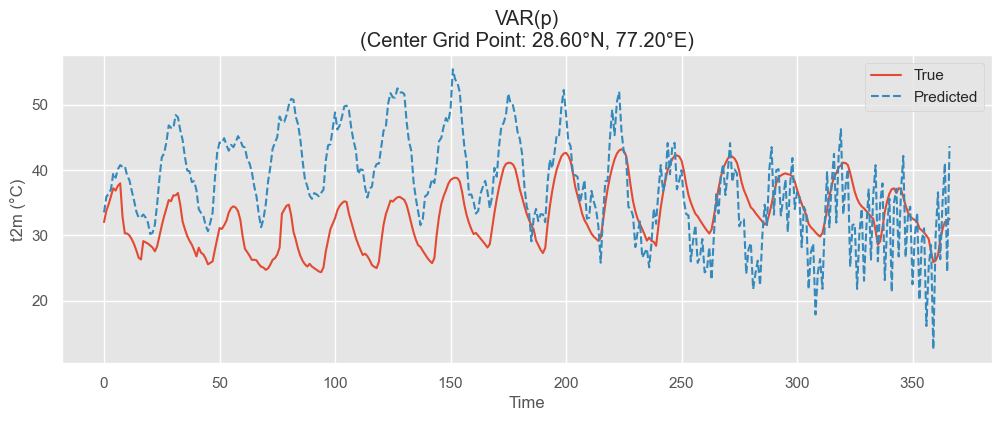

In [139]:
plt.figure(figsize=(12, 4))
plt.plot(x_test, label="True")
plt.plot(center_pred_test_VAR, '--', label="Predicted")
plt.title(f"VAR(p)\n(Center Grid Point: {data.latitude.values[5]:.2f}°N, {data.longitude.values[5]:.2f}°E)")
plt.xlabel("Time")
plt.ylabel("t2m (°C)")
plt.legend()
plt.grid(True)
plt.show()

In [140]:
k_ar = result_final.k_ar  # lag used in the VAR model

# Correct the date ranges
dates_train_adj = dates_train[k_ar:]
dates_test_adj = dates_test[k_ar: ]

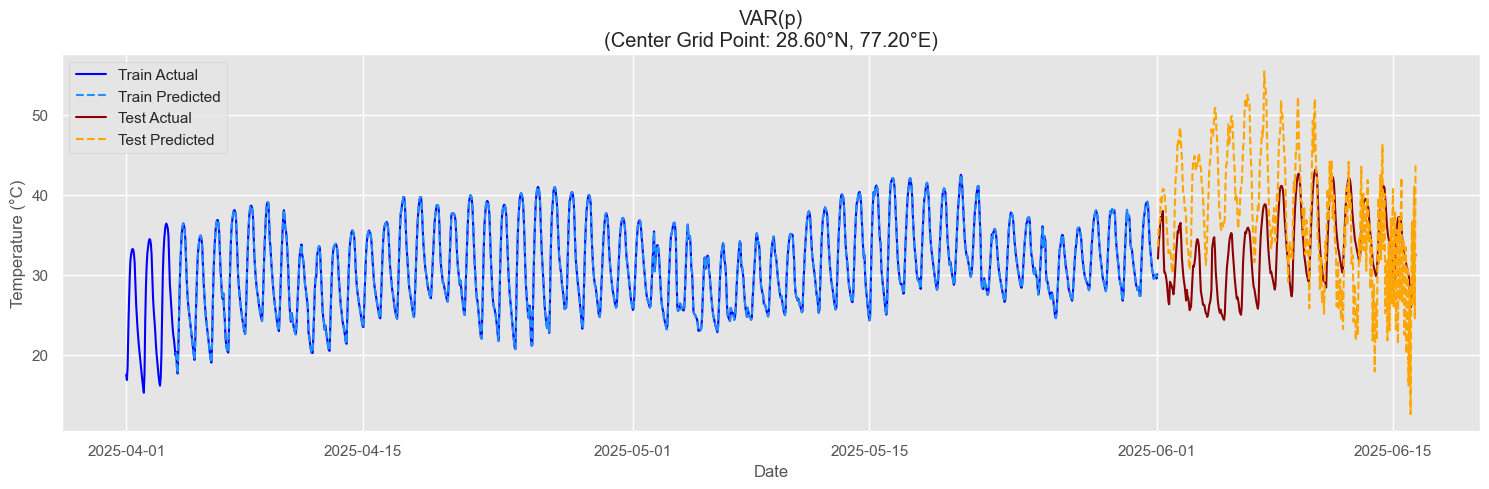

In [141]:
plt.figure(figsize=(15, 5))

sns.lineplot(x=dates_train, y=x_train, label='Train Actual', color='blue')
sns.lineplot(x=dates_train_adj, y=center_pred_train_VAR, label='Train Predicted', color='dodgerblue', linestyle='--')
sns.lineplot(x=dates_test, y=x_test, label='Test Actual', color='darkred')
sns.lineplot(x=dates_test, y=center_pred_test_VAR, label='Test Predicted', color='orange', linestyle='--')

plt.title(f"VAR(p)\n(Center Grid Point: {data.latitude.values[5]:.2f}°N, {data.longitude.values[5]:.2f}°E)")
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.tight_layout()
plt.legend()
plt.show()

While AR(p) model captures some of the short-term dependencies better than the periodic model, it clearly overfits which is most likely attributed to the high dimension of the data. Hence, this will be addressed via dimensionality reduction. 

# Dimensionality Reduction 

Dimensionality reduction methods with POD and DMD are explored to reduce the dimensions of the high dimensional input data. 

## POD

In [77]:
X_train_centered = X_train_C - X_train_C.mean(axis=0)
U, S, VT = np.linalg.svd(X_train_centered, full_matrices=False)

/var/folders/cj/llkf44_x1l59w05w6z2bwr0c0000gp/T/ipykernel_91519/1865221844.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


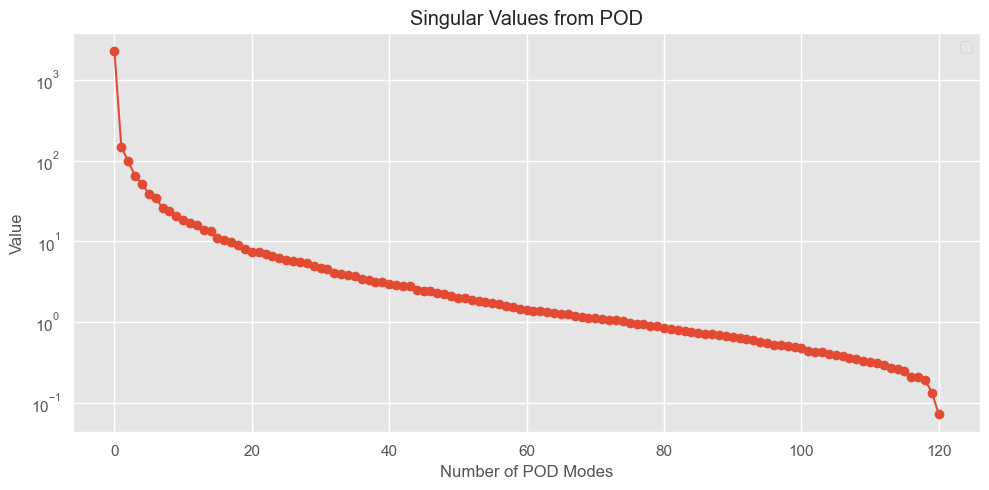

In [79]:
# Plot: POD cumulative variance
plt.style.use('ggplot')
plt.figure(figsize=(10, 5))
plt.semilogy(S, marker = 'o')
plt.title('Singular Values from POD')
plt.xlabel('Number of POD Modes')
plt.ylabel('Value')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

As seen from the plot, the first 7 modes (elbow point) gives a good trade-off between dimension reduction and information retention. 

We can reconstruct the data with both 7 modes and 20 modes

In [80]:
k = 7
U_k = U[:, :k]            # (1466, p)
S_k = np.diag(S[:k])      # (p, p)
V_k = VT[:k, :]           # (p, 121)

# Compressed approximation (still centered):
X_approx_centered = U_k @ S_k @ V_k

# If you subtracted mean earlier, add it back:
X_approx_POD = X_approx_centered + X_train_C.mean(axis=0)

# Project centered data onto spatial basis (V_p.T) --> use for training
coeffs_POD = X_train_centered @ V_k.T  # (1466, p)

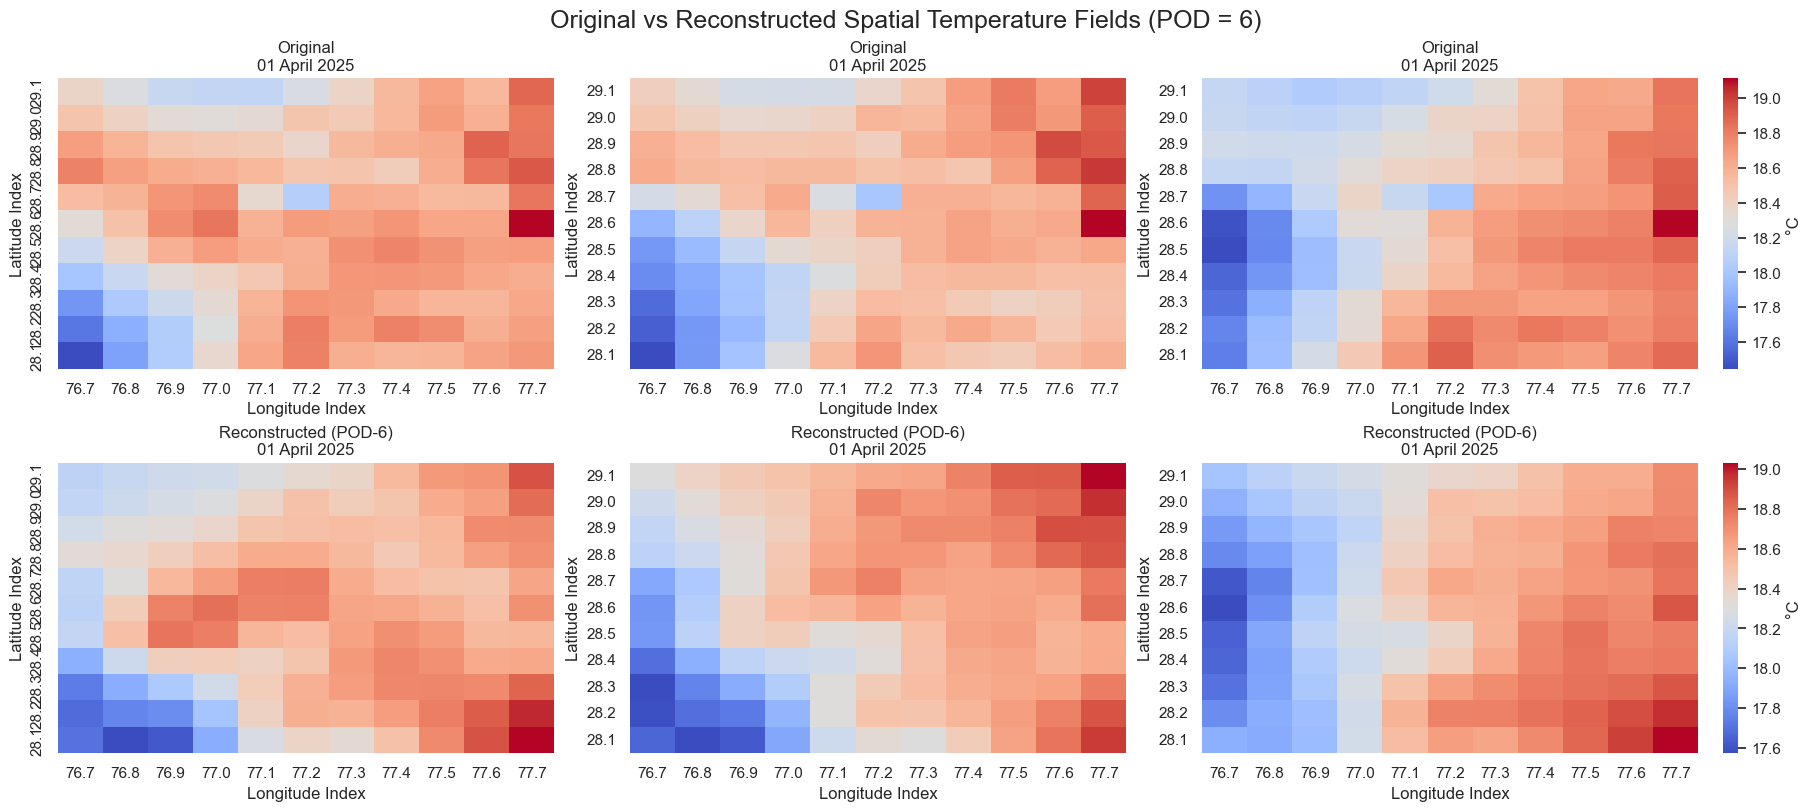

In [81]:
sns.set(style="white")

# Automatically pick the first 3 dates in the dataset
dates = temp_c.valid_time.values[:3]
titles = [pd.to_datetime(d).strftime('%d %B %Y') for d in dates]

# Set up subplots (2 rows: original & reconstructed)
fig, axes = plt.subplots(2, 3, figsize=(18, 8), constrained_layout=True)

xticks = np.round(temp_c.longitude.values, 2)
yticks = np.round(temp_c.latitude.values, 2)

for i, date in enumerate(dates):
    # Get original snapshot
    snapshot = temp_c.sel(valid_time=date).values  # shape: (11, 11)

    # Get index corresponding to this date
    time_index = temp_c.get_index("valid_time").get_loc(date)

    # Get compressed snapshot
    snapshot_flat = X_approx_POD[time_index]          # shape: (121,)
    snapshot_recon = snapshot_flat.reshape(11, 11)

    # Plot original
    sns.heatmap(snapshot,
                xticklabels=xticks,
                yticklabels=yticks,
                cmap='coolwarm',
                ax=axes[0, i],
                cbar=i == 2,
                cbar_kws={'label': '°C'} if i == 2 else None)
    axes[0, i].set_title(f"Original\n{titles[i]}")
    axes[0, i].set_xlabel("Longitude Index")
    axes[0, i].set_ylabel("Latitude Index")

    # Plot reconstructed
    sns.heatmap(snapshot_recon,
                xticklabels=xticks,
                yticklabels=yticks,
                cmap='coolwarm',
                ax=axes[1, i],
                cbar=i == 2,
                cbar_kws={'label': '°C'} if i == 2 else None)
    axes[1, i].set_title(f"Reconstructed (POD-6)\n{titles[i]}")
    axes[1, i].set_xlabel("Longitude Index")
    axes[1, i].set_ylabel("Latitude Index")

plt.suptitle("Original vs Reconstructed Spatial Temperature Fields (POD = 6)", fontsize=18)
plt.show()

The reconstruction seems to be very similar to the original data. Now we can fit the reduced data to our VAR(p) model again. We will continue to select the best order p first in the similar manner, and then train and evaluate the final model with the best order p.  

In [126]:
V_k = VT[:k, :] 

A_train = X_train_centered @ V_k.T  # Shape: (1466, 7)
A_test = X_test @ V_k.T  

In [127]:
split_index = int(0.8 * len(A_train)) 

A_train_sub = A_train[:split_index]
A_valid = A_train[split_index:]

In [128]:
p_range = range(1, 101, 10)
val_mse_list = []

for p in tqdm(p_range):
    model = VAR(A_train_sub)
    results = model.fit(maxlags=p)

    # Forecast validation data
    forecast = results.forecast(A_train_sub[-p:], steps=len(A_valid))

    # Compute error
    mse = mean_squared_error(A_valid, forecast)
    val_mse_list.append(mse)

best_p = p_range[np.argmin(val_mse_list)]
print(f"Selected AR order: p = {best_p}")

100%|██████████| 10/10 [00:05<00:00,  1.89it/s]

Selected AR order: p = 51


In [129]:
# Train POD model
result_final = VAR(A_train).fit(maxlags=best_p)

In [130]:
# Forecast on train and test
A_pred_train_POD = result_final.fittedvalues
A_pred_test_POD = result_final.forecast(y=A_train[-result_final.k_ar:], steps=len(A_test))

# Adjust to full space 
X_pred_train_centered = A_pred_train_POD @ V_k 
X_pred_train_POD = X_pred_train_centered + X_train_C.mean(axis=0) # un-center it

X_pred_test_centered = A_pred_test_POD @ V_k 
X_pred_test_POD = X_pred_test_centered + X_train_C.mean(axis=0) # un-center it
 
#Compute MSE
mse_train = mean_squared_error(X_train_C[result_final.k_ar:], X_pred_train_POD)
mse_test = mean_squared_error(X_test_C, X_pred_test_POD)

print(f"Train MSE: {mse_train:.4f}")
print(f"Test MSE: {mse_test:.4f}")


Train MSE: 0.1877
Test MSE: 12.6237


In [131]:
center_pred_train_POD = X_pred_train_POD[:, center_idx]
center_pred_test_POD = X_pred_test_POD[:, center_idx]

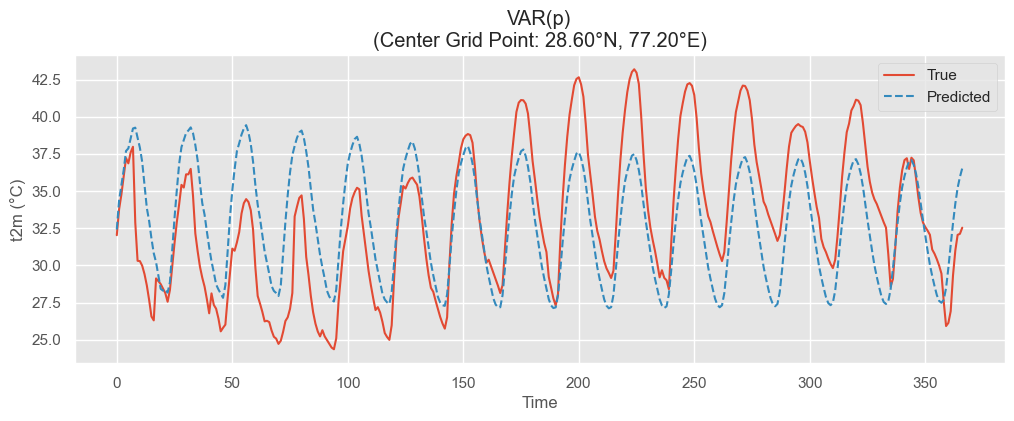

In [132]:
plt.figure(figsize=(12, 4))
plt.style.use('ggplot')
plt.plot(x_test, label="True")
plt.plot(center_pred_test_POD, '--', label="Predicted")
plt.title(f"VAR(p)\n(Center Grid Point: {data.latitude.values[5]:.2f}°N, {data.longitude.values[5]:.2f}°E)")
plt.xlabel("Time")
plt.ylabel("t2m (°C)")
plt.legend()
plt.grid(True)
plt.show()

In [133]:
k_ar = result_final.k_ar  # lag used in the VAR model

# Correct the date ranges
dates_train_adj = dates_train[k_ar:]
dates_test_adj = dates_test[k_ar: ]

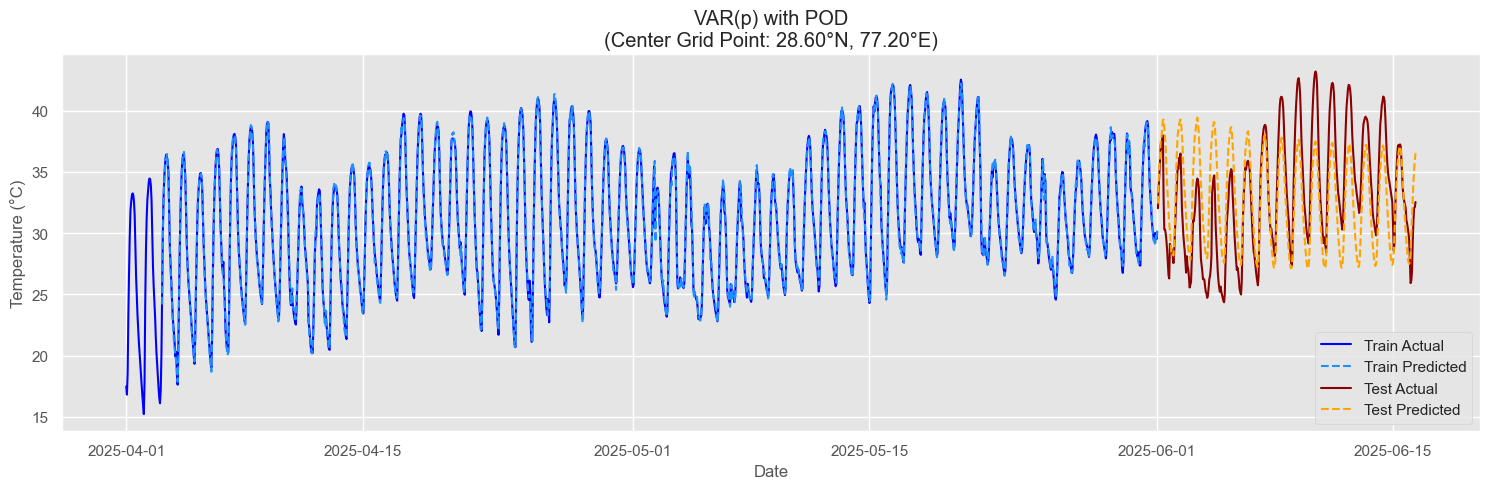

In [134]:
plt.figure(figsize=(15, 5))

sns.lineplot(x=dates_train, y=x_train, label='Train Actual', color='blue')
sns.lineplot(x=dates_train_adj, y=center_pred_train_POD, label='Train Predicted', color='dodgerblue', linestyle='--')
sns.lineplot(x=dates_test, y=x_test, label='Test Actual', color='darkred')
sns.lineplot(x=dates_test, y=center_pred_test_POD, label='Test Predicted', color='orange', linestyle='--')

plt.title(f"VAR(p) with POD\n(Center Grid Point: {data.latitude.values[5]:.2f}°N, {data.longitude.values[5]:.2f}°E)")
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.tight_layout()
plt.legend()
plt.show()

Using POD for dimensionality reduction has evidently improved the performance. It has not only reduced overfitting, but also improved its predictability, surpassing the performance of periodic regression.  

## DMD

For DMD, we will be using a python package `pydmd` which implements the DMD method for us. 

In [228]:
# choosing svd_rank = 0 automatically selects the optimal dimension 
dmd = DMD(svd_rank=0) 
# we take the transpose since the DMD excepts each column to be a time snapshot 
#(our data has each row as the time snapshot)
dmd.fit(X_train_C.T)

/Users/sneha/opt/anaconda3/envs/dsa5206_proj/lib/python3.12/site-packages/pydmd/snapshots.py:73: UserWarning: Input data condition number 179121.640625. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(


In [229]:
# Results
modes = dmd.modes
eigvals = dmd.eigs 
X_dmd_reconstructed = dmd.reconstructed_data.real

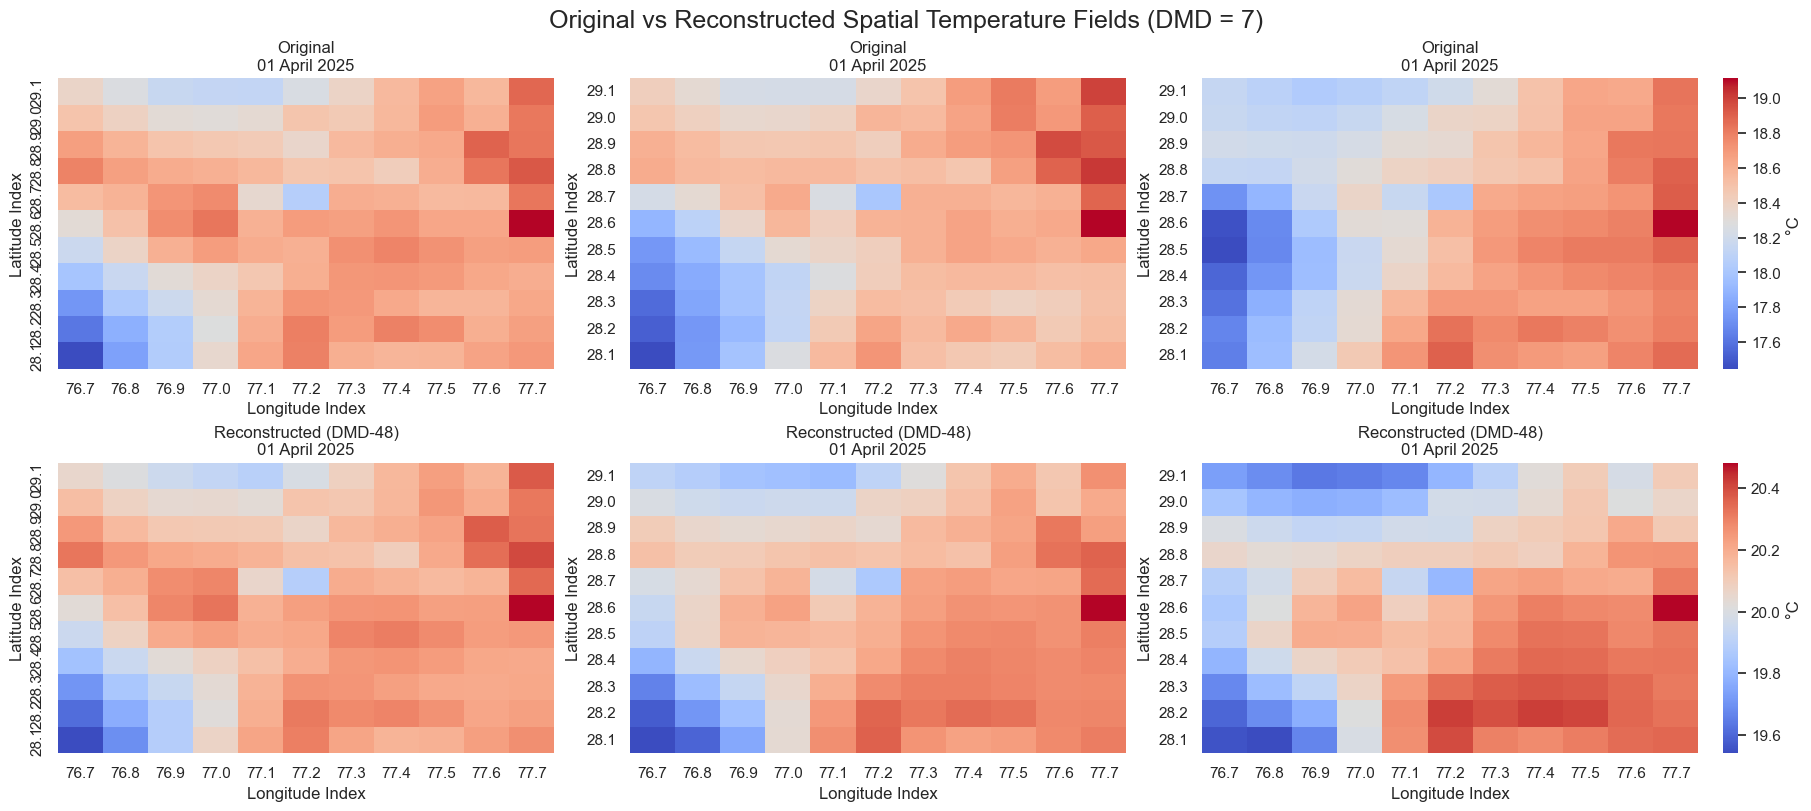

In [241]:
sns.set(style="white")

# First 3 dates and formatted titles
dates = temp_c.valid_time.values[:3]
titles = [pd.to_datetime(d).strftime('%d %B %Y') for d in dates]

fig, axes = plt.subplots(2, 3, figsize=(18, 8), constrained_layout=True)

xticks = np.round(temp_c.longitude.values, 2)
yticks = np.round(temp_c.latitude.values, 2)

for i, date in enumerate(dates):
    # Original snapshot
    snapshot = temp_c.sel(valid_time=date).values  # shape: (11, 11)

    # Get corresponding time index
    time_index = temp_c.get_index("valid_time").get_loc(date)

    # DMD reconstruction
    snapshot_flat_dmd = X_dmd_reconstructed[:, time_index]     # (121,)
    snapshot_recon_dmd = snapshot_flat_dmd.reshape(11, 11)  # (11, 11)

    # Plot original
    sns.heatmap(snapshot,
                xticklabels=xticks,
                yticklabels=yticks,
                cmap='coolwarm',
                ax=axes[0, i],
                cbar=i == 2,
                cbar_kws={'label': '°C'} if i == 2 else None)
    axes[0, i].set_title(f"Original\n{titles[i]}")
    axes[0, i].set_xlabel("Longitude Index")
    axes[0, i].set_ylabel("Latitude Index")

    # Plot reconstructed
    sns.heatmap(snapshot_recon_dmd,
                xticklabels=xticks,
                yticklabels=yticks,
                cmap='coolwarm',
                ax=axes[1, i],
                cbar=i == 2,
                cbar_kws={'label': '°C'} if i == 2 else None)
    axes[1, i].set_title(f"Reconstructed (DMD-{modes.shape[1]})\n{titles[i]}")
    axes[1, i].set_xlabel("Longitude Index")
    axes[1, i].set_ylabel("Latitude Index")

plt.suptitle(f"Original vs Reconstructed Spatial Temperature Fields (DMD = {r})", fontsize=18)
plt.show()


The reconstructed data with DMD modes is very similar to the original data. Now, we can also implement this with the VAR(p) model. 

In [231]:
# DMD-reduced data 
X_train_dmd = dmd.dynamics.real.T

# project test data to dmd basis 
Phi = dmd.modes.real 
Phi_pinv = pinv(Phi)
X_test_dmd = (Phi_pinv @ X_test_C.T).T

In [233]:
split_index = int(0.8 * len(X_train_dmd)) 

X_train_sub_dmd = X_train_dmd[:split_index]
X_valid_dmd = X_train_dmd[split_index:]

In [234]:
p_range = range(1, 101, 10)
val_mse_list = []

for p in tqdm(p_range):
    model = VAR(X_train_sub_dmd)
    results = model.fit(maxlags=p)

    # Forecast validation data
    forecast = results.forecast(X_train_sub_dmd[-p:], steps=len(X_valid_dmd))

    # Compute error
    mse = mean_squared_error(X_valid_dmd, forecast)
    val_mse_list.append(mse)

best_p = p_range[np.argmin(val_mse_list)]
print(f"Selected AR order: p = {best_p}")

100%|██████████| 10/10 [00:27<00:00,  2.76s/it]

Selected AR order: p = 61


In [235]:
# Train DMD model
result_final = VAR(X_train_dmd).fit(maxlags=best_p)

In [236]:
X_pred_train_DMD = result_final.fittedvalues
X_pred_test_DMD = result_final.forecast(y=X_train_dmd[-result_final.k_ar:], steps =len(X_test_dmd))

X_pred_train_full = X_pred_train_DMD @ Phi.T
X_pred_test_full = X_pred_test_DMD @ Phi.T

mse_train = mean_squared_error(X_train_C[result_final.k_ar:], X_pred_train_full)
mse_test = mean_squared_error(X_test_C, X_pred_test_full)

print(f"Train MSE: {mse_train:.4f}")
print(f"Test MSE: {mse_test:.4f}")

Train MSE: 764.1459
Test MSE: 1105.1540


In [237]:
center_pred_train_DMD = X_pred_train_full[:, center_idx]
center_pred_test_DMD = X_pred_test_full[:, center_idx]

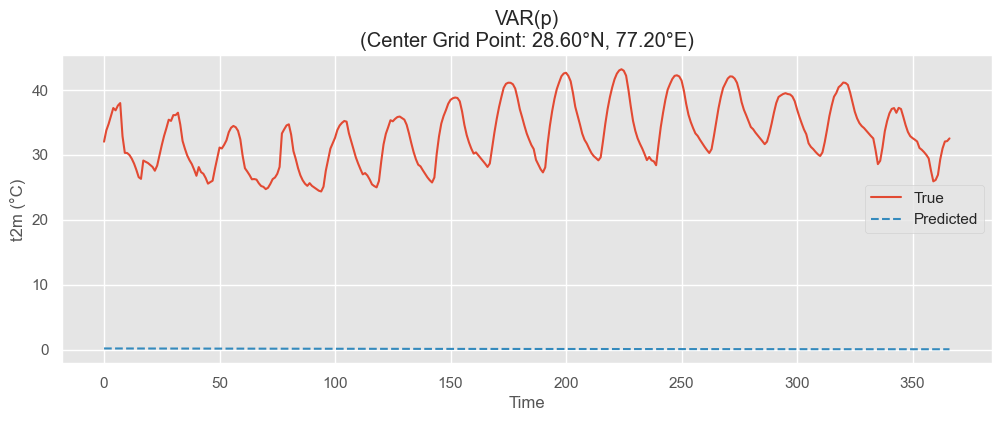

In [238]:
plt.figure(figsize=(12, 4))
plt.style.use('ggplot')
plt.plot(x_test, label="True")
plt.plot(center_pred_test_DMD, '--', label="Predicted")
plt.title(f"VAR(p)\n(Center Grid Point: {data.latitude.values[5]:.2f}°N, {data.longitude.values[5]:.2f}°E)")
plt.xlabel("Time")
plt.ylabel("t2m (°C)")
plt.legend()
plt.grid(True)
plt.show()

In [239]:
k_ar = result_final.k_ar  # lag used in the VAR model

# Correct the date ranges
dates_train_adj = dates_train[k_ar:]
dates_test_adj = dates_test[k_ar: ]

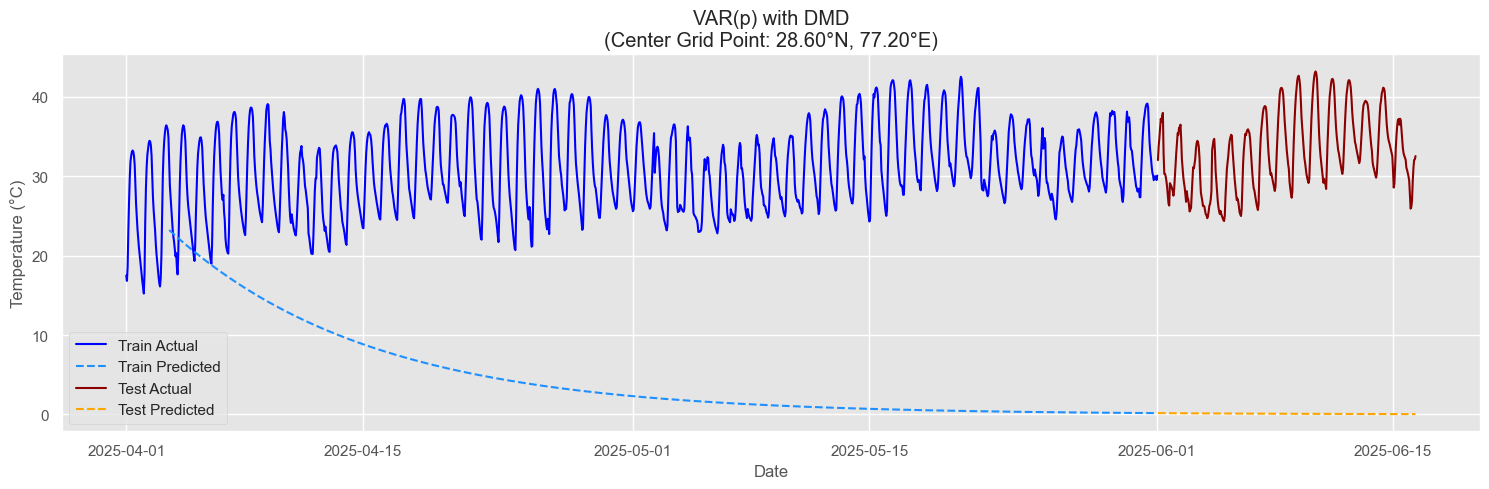

In [240]:
plt.figure(figsize=(15, 5))
plt.style.use('ggplot')
sns.lineplot(x=dates_train, y=x_train, label='Train Actual', color='blue')
sns.lineplot(x=dates_train_adj, y=center_pred_train_DMD, label='Train Predicted', color='dodgerblue', linestyle='--')
sns.lineplot(x=dates_test, y=x_test, label='Test Actual', color='darkred')
sns.lineplot(x=dates_test, y=center_pred_test_DMD, label='Test Predicted', color='orange', linestyle='--')

plt.title(f"VAR(p) with DMD\n(Center Grid Point: {data.latitude.values[5]:.2f}°N, {data.longitude.values[5]:.2f}°E)")
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.tight_layout()
plt.legend()
plt.show()

The predictions are not very accurate, and worse than before applying dimensionality reduction. This is most likely because the DMD method is linear and fails to capture the non-linear dynamics. 